In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

In [2]:
colnames = [
    "loc_rowid","kepid","kepoi_name","kepler_name","koi_disposition",
    "koi_pdisposition","koi_score","koi_fpflag_nt","koi_fpflag_ss",
    "koi_fpflag_co","koi_fpflag_ec","koi_period","koi_period_err1",
    "koi_period_err2","koi_time0bk","koi_time0bk_err1","koi_time0bk_err2",
    "koi_impact","koi_impact_err1","koi_impact_err2","koi_duration",
    "koi_duration_err1","koi_duration_err2","koi_depth","koi_depth_err1",
    "koi_depth_err2","koi_prad","koi_prad_err1","koi_prad_err2",
    "koi_teq","koi_teq_err1","koi_teq_err2","koi_insol","koi_insol_err1",
    "koi_insol_err2","koi_model_snr","koi_tce_plnt_num","koi_tce_delivname",
    "koi_steff","koi_steff_err1","koi_steff_err2","koi_slogg","koi_slogg_err1",
    "koi_slogg_err2","koi_srad","koi_srad_err1","koi_srad_err2",
    "ra","dec","koi_kepmag"
]

data = pd.read_csv(
    "/Users/philipkaloudis/Documents/Kepler_NASA_data.csv",
    skiprows=31,   # skip metadata/dictionary
    names=colnames,  # force column names if the CSV header is missing
    header=None,     # treat first line after skiprows as data (not header)
    comment="#"      # ignore comment lines
)

In [3]:
# Drop the first row (index 0)
data = data.drop(data.index[0])

# Reset index if you want sequential numbering
data = data.reset_index(drop=True)

In [4]:
#Remove ID columns and errors that will not be taken into account in the model

data2=data.drop(columns=["loc_rowid", "kepid", "kepoi_name", "kepler_name", "koi_period_err1", "koi_period_err2", "koi_time0bk_err1", "koi_time0bk_err2", "koi_impact_err1", "koi_impact_err2", "koi_duration_err1", "koi_duration_err2", "koi_depth_err1", "koi_depth_err2", "koi_teq_err1", "koi_teq_err2", "koi_insol_err1", "koi_insol_err2", "koi_steff_err1", "koi_steff_err2", "koi_slogg_err1", "koi_slogg_err2", "koi_srad_err1", "koi_srad_err2", "koi_prad_err1", "koi_prad_err2", "koi_pdisposition", "koi_tce_delivname"])

features = data2.drop("koi_disposition", axis=1)
targets = data2["koi_disposition"]

In [5]:
#Take care of missing values in the koi_score column by replacing them with the mode of the rest of the values (histogram shows that mean/median are bad choice)
#Take care of missing values in the koi_impact column by replacing them with the median of the rest of the data (histogram shows this is a good choice)
#Same as above for koi_depth

features["koi_score"] = features["koi_score"].astype(float)
features["koi_score"] = features["koi_score"].fillna(features["koi_score"].mode()[0])

features["koi_impact"] = features["koi_impact"].astype(float)
features["koi_impact"] = features["koi_impact"].fillna(features["koi_impact"].median())

features["koi_depth"] = features["koi_depth"].astype(float)
features["koi_depth"] = features["koi_depth"].fillna(features["koi_impact"].median())

features["koi_prad"] = features["koi_prad"].astype(float)
features["koi_prad"] = features["koi_prad"].fillna(features["koi_prad"].median())

features["koi_teq"] = features["koi_teq"].astype(float)
features["koi_teq"] = features["koi_teq"].fillna(features["koi_teq"].median())

features = features.astype(float)

imputer = SimpleImputer(strategy="median")

training_features = pd.DataFrame(
    imputer.fit_transform(features),
    columns=features.columns,
    index=features.index  # keep the same row labels
)



In [6]:
scaler = StandardScaler()
encoder = OneHotEncoder(sparse_output=False)

training_features_scaled = pd.DataFrame(
    scaler.fit_transform(training_features),
    columns=training_features.columns,
    index=training_features.index
)

targets_final = encoder.fit_transform(targets.values.reshape(-1,1))

targets_series = pd.Series(targets_final[:, 0], index=training_features_scaled.index)

#training_features_train, training_features_test, targets_final_train, targets_final_test = train_test_split(training_features_scaled, targets_final, test_size=0.2, stratify=targets_final, random_state=42)

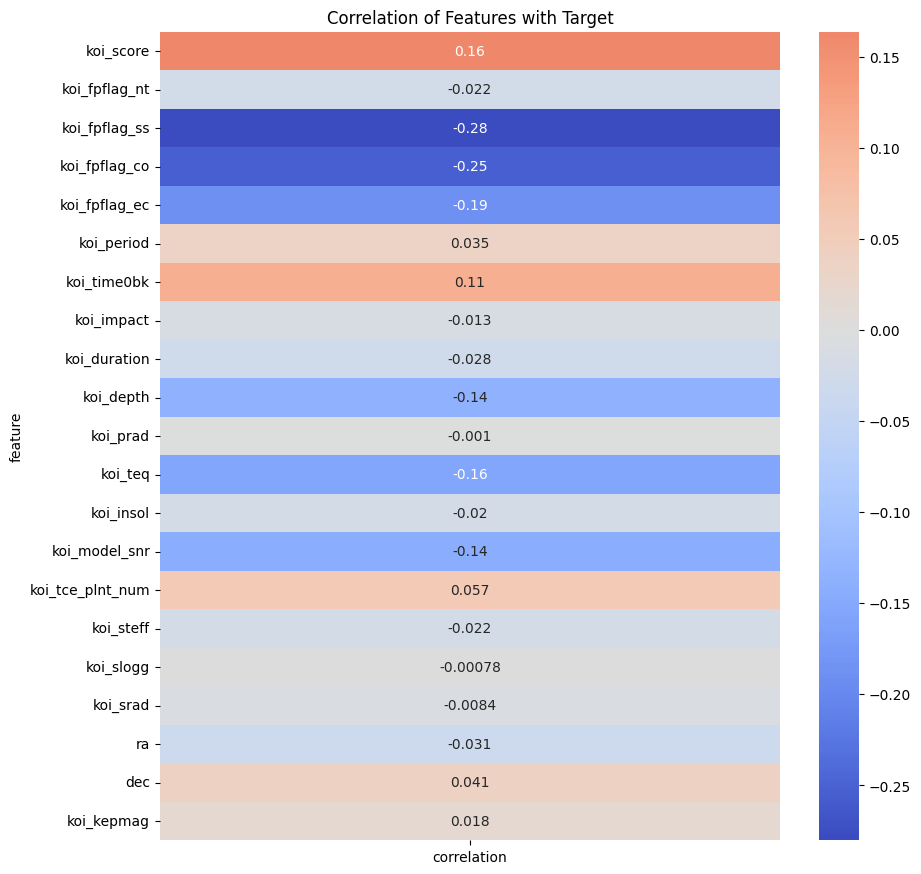

In [7]:
correlations = training_features_scaled.corrwith(targets_series)
corr_df = correlations.to_frame(name='correlation')
corr_df.index.name = 'feature'  # optional, for labeling
corr_df.reset_index(inplace=True)

plt.figure(figsize=(10, len(corr_df)*0.5))  # height depends on number of features
sns.heatmap(
    corr_df.set_index('feature'),   # features as rows
    annot=True,                     # show correlation numbers
    cmap='coolwarm',                # red-blue diverging colors
    center=0                         # zero correlation is neutral
)
plt.title("Correlation of Features with Target")
plt.show()

In [8]:
columns_to_keep = ["koi_score", "koi_fpflag_ss", "koi_fpflag_co", "koi_fpflag_ec", "koi_time0bk", "koi_depth", "koi_teq", "koi_model_snr"]
training_features_scaled_final = training_features_scaled[columns_to_keep]

In [21]:
training_features_train, training_features_test, targets_final_train, targets_final_test = train_test_split(training_features_scaled_final, targets_series, test_size=0.2, stratify=targets_final, random_state=42)
parameters = {"n_neighbors":[10, 11, 12], "weights":["uniform", "distance"]}
classifier = KNeighborsClassifier()
clf = GridSearchCV(classifier, parameters)
clf.fit(training_features_train, targets_final_train)

,estimator,KNeighborsClassifier()
,param_grid,"{'n_neighbors': [10, 11, ...], 'weights': ['uniform', 'distance']}"
,scoring,None
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,12


In [22]:
targets_predict = clf.predict(training_features_test)
scores=cross_val_score(clf, training_features_test, targets_final_test, cv=10, scoring="accuracy")

In [23]:
print(scores)

[0.796875   0.80208333 0.8125     0.79057592 0.80104712 0.78010471
 0.80104712 0.78010471 0.76963351 0.79581152]


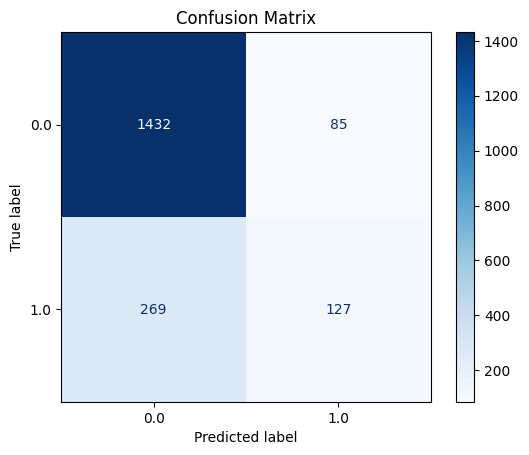

In [26]:
cm = confusion_matrix(targets_final_test, targets_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

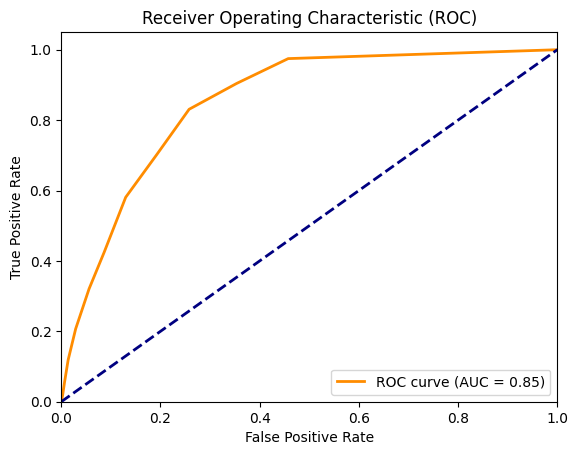

In [27]:
y_score = clf.predict_proba(training_features_test)[:, 1]  # probability for positive class

fpr, tpr, thresholds = roc_curve(targets_final_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()